# The Future of Energy Consumption for Heating and Cooling
\
In this project, I use climate model data to estimate future energy consumption for space heating and air conditioning for 32 countries. These countires represent over 65% of global population.

### Analysis 

1. Plotting change in GDP, population, and heating/cooling degree days for each country
2. Clustering countries based on their current energy usage
3. Method 1: Creating a uniform "score" for potential future contribution (i.e., normalizing changes in variables)
4. Method 2: Multiple regression between GDP, population, heating/cooling degree days, and heat/air conditioner energy use
5. Method 3: Simple regression between heating/cooling degree days and heat/air conditioner energy use

### Data

- [CMIP6 data](https://cds.climate.copernicus.eu/): CESM surface air temperature for 2016 and 2050 using SSP2
- [Current & future GDP and population data for 32 countries](https://www.pwc.com/gx/en/research-insights/economy/the-world-in-2050.html#data)
- Current energy used for air conditioning and heating ([various sources](https://leap.2i2c.cloud/hub/user-redirect/lab/tree/final_project_Cockburn/gdp_pop_2050.xlsx))
- [Shapefile of countries](https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip)

In [1]:
#firstly I had to install the CDS API to pull the data 
#conda install cdsapi
#pip install 'cdsapi>=0.7.2'

#Also: 

#pip install openpyxl

In [112]:
#Import statements

import cdsapi
import xarray as xr
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs, feature as cfeature
import pandas as pd
import geopandas as gpd
import requests
import zipfile
import io
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches
import textwrap
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import warnings

#warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

### 1a. Pulling CMIP6 data from Climate Data Store: 

In [113]:
def download_cmip6_data(modelname): 
    dataset = "projections-cmip6"
    request = {
        "temporal_resolution": "daily",
        "experiment": "ssp2_4_5",
        "variable": "near_surface_air_temperature",
        "model": modelname,
        "year": ["2016", "2050"],
        "month": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12"
        ],
        "day": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12",
            "13", "14", "15",
            "16", "17", "18",
            "19", "20", "21",
            "22", "23", "24",
            "25", "26", "27",
            "28", "29", "30",
            "31"
        ]
    }
    client = cdsapi.Client()
    target = 'cmip6_files.zip'
    client.retrieve(dataset, request, target)

    #Extract nc file and move it back
    #Path to the ZIP file
    zip_path = "cmip6_files.zip"
    extract_to = "cmip6"
    
    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)


In [3]:
#to download the data!
download_cmip6_data('cesm2')

2024-12-04 15:49:24,676 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-12-04 15:49:24,700 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-04 15:49:24,700 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-12-04 15:49:24,701 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

77e09ae90014820cd6e3050eaaf23e8d.zip:   0%|          | 0.00/86.1M [00:00<?, ?B/s]

### 1b. Reading in the data, calculating changes in heating/cooling degree days

In [114]:
# Get it into xarray
ds = xr.open_dataset('cmip6/tas_day_CESM2_ssp245_r4i1p1f1_gn_20160101-20501231.nc')
#convert t from K to C

ds['tas'] = ds['tas'] - 273.15

ds_2016 = ds.sel(time=slice("2016-01-01", "2016-12-31"))
ds_2050 = ds.sel(time=slice("2050-01-01", "2050-12-31"))

In [115]:
# Calculate number of heating degree-days and cooling degree-days for 2016 and 2050 for each grid cell

hdd_2016 = xr.where(ds_2016['tas'] < 18, 18 - ds_2016['tas'], 0).sum(dim='time')
cdd_2016 = xr.where(ds_2016['tas'] > 22, ds_2016['tas'] + 22, 0).sum(dim='time')
hdd_2050 = xr.where(ds_2050['tas'] < 18, 18 - ds_2050['tas'], 0).sum(dim='time')
cdd_2050 = xr.where(ds_2050['tas'] > 22, ds_2050['tas'] + 22, 0).sum(dim='time')

In [116]:
# Setting extent 
projPC = ccrs.PlateCarree()
lonW = -180
lonE = 180
latS = -60
latN = 90
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2

### 1c. Plotting changes in heating/cooling degree days

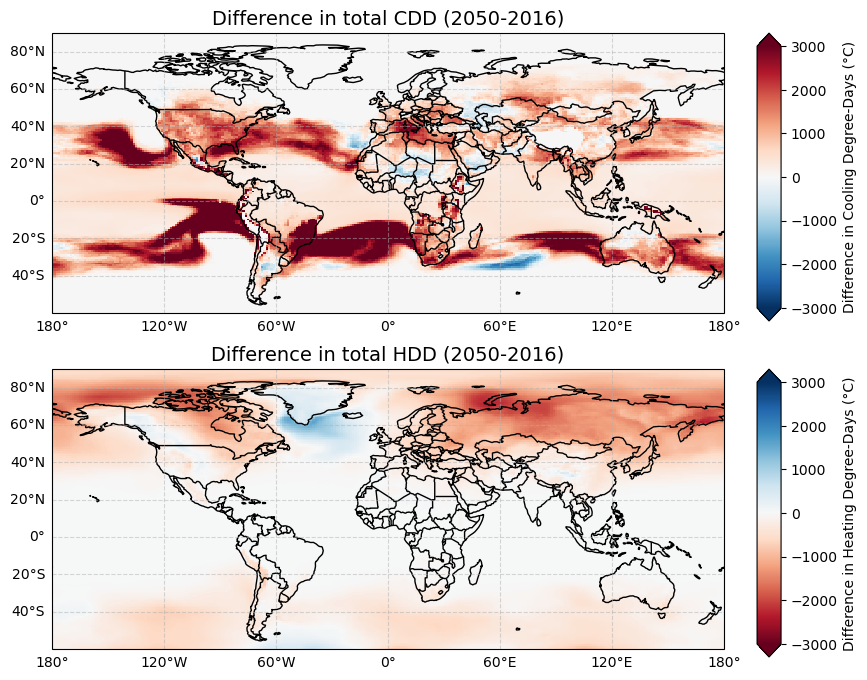

In [117]:
#PLOT THE DIFFERENCE 
diff_cdd = cdd_2050 - cdd_2016

# Create the main plot with specified figure size
fig, ax = plt.subplots(2, 1, figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the HDD data
diff_cdd.plot(
    ax=ax[0],
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",  # Choose a color map
    vmin=-3000,
    vmax=3000,
    cbar_ax=fig.add_axes([0.82, 0.52, 0.02, 0.36]),  # Position and size of colorbar
    cbar_kwargs={"label": "Difference in Cooling Degree-Days (°C)", "extend": "both"}
)
ax[0].set_extent([lonW, lonE, latS, latN], crs=projPC)

# Add coastlines and features
ax[0].coastlines()
ax[0].add_feature(cfeature.BORDERS, linestyle='-')
ax[0].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.5)
ax[0].add_feature(cfeature.OCEAN, edgecolor='black', facecolor='lightblue', alpha=0.5)

# Add gridlines
gl = ax[0].gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = gl.right_labels = False  # Remove labels from top and right

# Add a title
ax[0].set_title("Difference in total CDD (2050-2016)", fontsize=14)

diff_hdd = hdd_2050 - hdd_2016

# Plot the HDD data
diff_hdd.plot(
    ax=ax[1],
    transform=ccrs.PlateCarree(),
    cmap="RdBu",  # Choose a color map
    vmin=-3000,
    vmax=3000,
    cbar_ax=fig.add_axes([0.82, 0.1, 0.02, 0.36]),  # Position and size of colorbar
    cbar_kwargs={"label": "Difference in Heating Degree-Days (°C)", "extend": "both"}
)
ax[1].set_extent([lonW, lonE, latS, latN], crs=projPC)

# Add coastlines and features
ax[1].coastlines()
ax[1].add_feature(cfeature.BORDERS, linestyle='-')
ax[1].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.5)
ax[1].add_feature(cfeature.OCEAN, edgecolor='black', facecolor='lightblue', alpha=0.5)

# Add gridlines
gl = ax[1].gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = gl.right_labels = False  # Remove labels from top and right

# Add a title
ax[1].set_title("Difference in total HDD (2050-2016)", fontsize=14)

# Show the plot
plt.show()

### 1d. Pulling in GDP/population/energy use data and assigning them to each country

In [118]:
# Make a function for downloading the shapefile I need to plot GDP change per country 

def download_shapefile(url, folder):
    # Check if we already have it 
    if not os.path.exists(folder):
        #Create folder
        os.makedirs(folder, exist_ok=True)
        response = requests.get(url)
        zip_path = os.path.join(folder, "natural_earth.zip")
        #Write the zip file
        with open(zip_path, "wb") as f:
            f.write(response.content)
        #now extract the files
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(folder)
            #Delete the zip file 
        os.remove(zip_path)  # Clean up ZIP file
    else:
        print("already have it ")


#URLs for the shapefile I need 
shapefile_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
shapefile_dir = "./natural_earth_shapefiles"

#Call function 
download_shapefile(shapefile_url, shapefile_dir)

already have it 


In [119]:
#Ok now read in the shapefile 
# Make sure you've run pip install openpyxl!!!
shapefile_path = os.path.join(shapefile_dir, "ne_110m_admin_0_countries.shp")
world = gpd.read_file(shapefile_path)

#NOW finally: load my excel file 
data = pd.read_excel("gdp_pop_2050.xlsx")

# Get change in and population 
data["gdp_change"] = data["gdp_2050"] - data["gdp_2016"]
data["pop_change"] = data["pop_2050"] - data["pop_2016"]


# Merge world countries with our countries 
world = world.rename(columns={"ADMIN": "Country"})  # Rename for consistency
world = world.merge(data, on="Country", how="left")
world['log_gdp_change'] = np.log(world['gdp_change'])

In [120]:
# GENERIC PLOTTING FUNCTION FOR THE COUNTRIES! 

def plot_countries(ax, data, column, cmap, extend, xlabel, title, vmin = None, vmax = None):
    
    image = data.plot(
        column=column,
        cmap=cmap,
        legend=True,
        ax=ax,
        missing_kwds={"color": "lightgrey"},
        legend_kwds={"orientation": "horizontal",
                     "extend": extend,
                     "pad": 0.05,
                    },
        vmin = vmin, 
        vmax = vmax
    )
    
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 12}
    gl.ylabel_style = {'fontsize': 12}
    
    cbar = fig.axes[-1]  # The last axis is the colorbar
    cbar.tick_params(labelsize=14)  # Adjust the tick label font size
    cbar.set_xlabel(xlabel, fontsize=14, labelpad=15)
    ax.set_title(title, fontsize=20)
    ax.set_axis_off()
    return cbar, image    

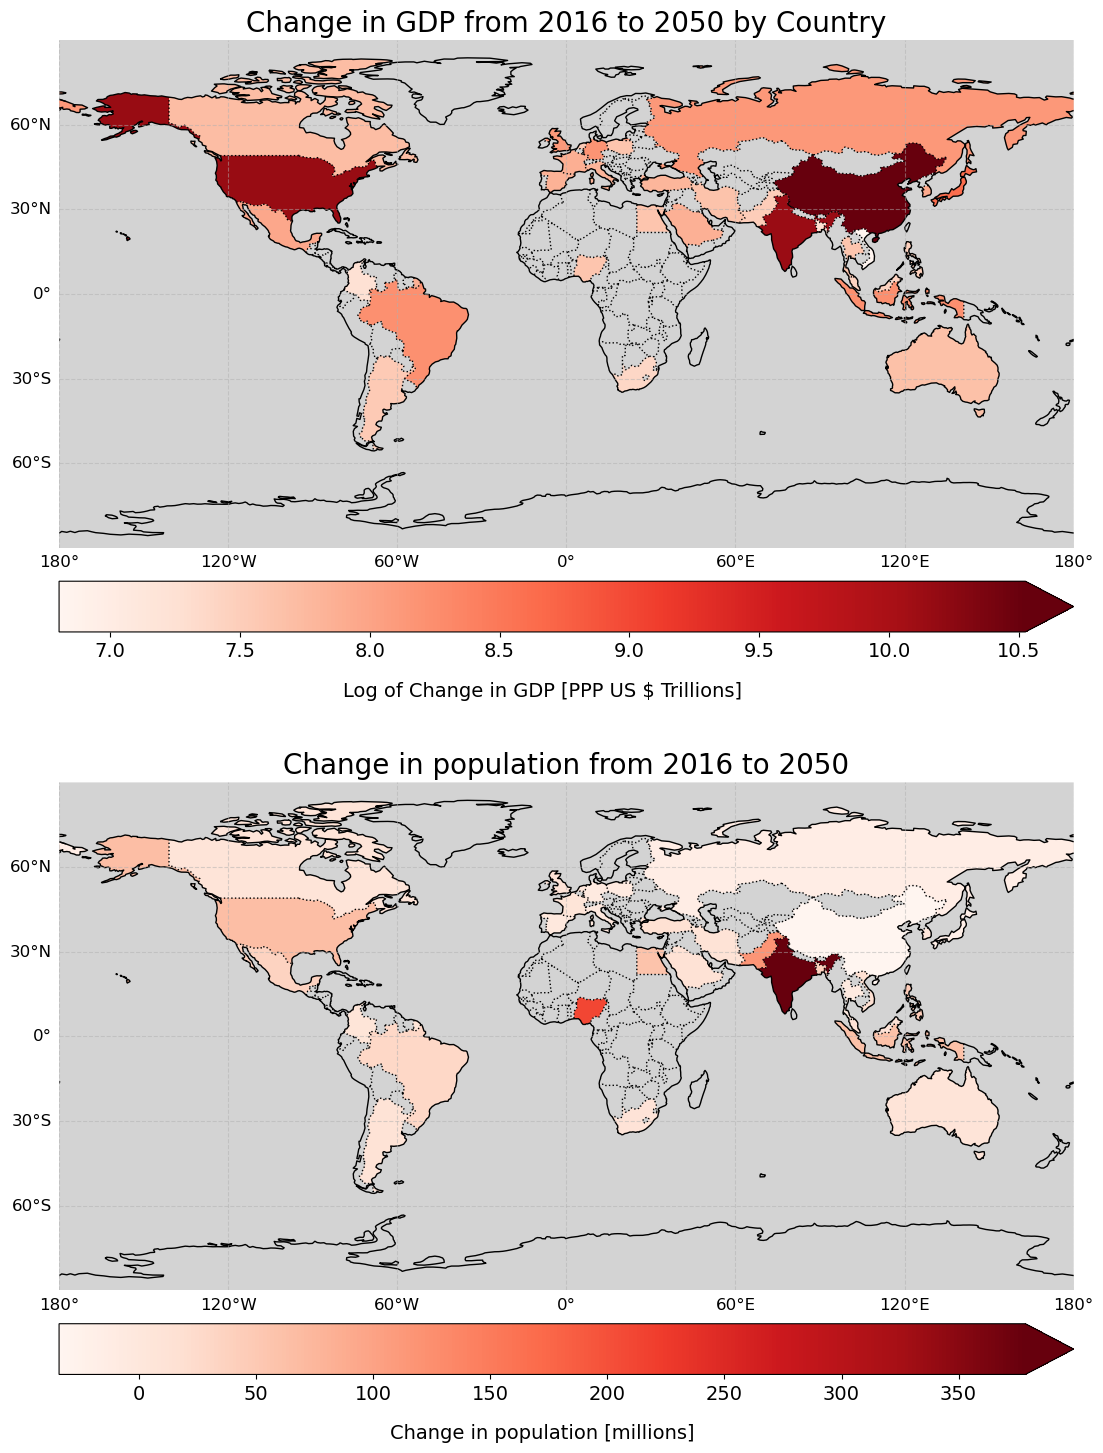

In [121]:
#Plotting GDP & population changes 

projection = ccrs.PlateCarree()
fig, ax = plt.subplots(2, 1, figsize=(11, 15), subplot_kw={'projection': projection})
cbar, image = plot_countries(ax[0], world, 'log_gdp_change', "Reds", "max", "Log of Change in GDP [PPP US $ Trillions]","Change in GDP from 2016 to 2050 by Country")
cbar, image = plot_countries(ax[1], world, 'pop_change', "Reds", "max", "Change in population [millions]","Change in population from 2016 to 2050")
plt.tight_layout()
plt.show()

In [122]:
# Get total change in CDD and HDD per country. Complicated!! Have to group them then take the mean for each country

#"Natural Earth data is unprojected degrees of latitude and longitude using the WGS84 datum."

#Function to get mean value of heating/cooling degree days within a country
def sum_values_within_country(country_geom, gdf):
    return gdf[gdf.geometry.within(country_geom)].value.mean()

#Function to add a column to the 'world' dataset
def add_field(dataset, field_name, target):
    #The lons don't match up! my data is from 0 to 360, other is from -180 to 180
    dataset2 = dataset.assign_coords(lon=(((dataset.lon + 180) % 360) - 180))
    lon, lat = np.meshgrid(dataset2.lon, dataset2.lat)
    dataset2 = dataset2.values
    df = pd.DataFrame({
        'lon': lon.flatten(),
        'lat': lat.flatten(),
        'value': dataset2.flatten()
    })
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    target[field_name] = target.geometry.apply(lambda x: sum_values_within_country(x, gdf))
    return target

diff_cdd = cdd_2050 - cdd_2016
world = add_field(diff_cdd, 'cdd_sum', world)
diff_hdd = hdd_2050 - hdd_2016
world = add_field(diff_hdd, 'hdd_sum', world)

#Now also add past and future hdd/cdd for later: 
world = add_field(cdd_2016, 'cdd_2016', world)
world = add_field(cdd_2050, 'cdd_2050', world)
world = add_field(hdd_2016, 'hdd_2016', world)
world = add_field(hdd_2050, 'hdd_2050', world)


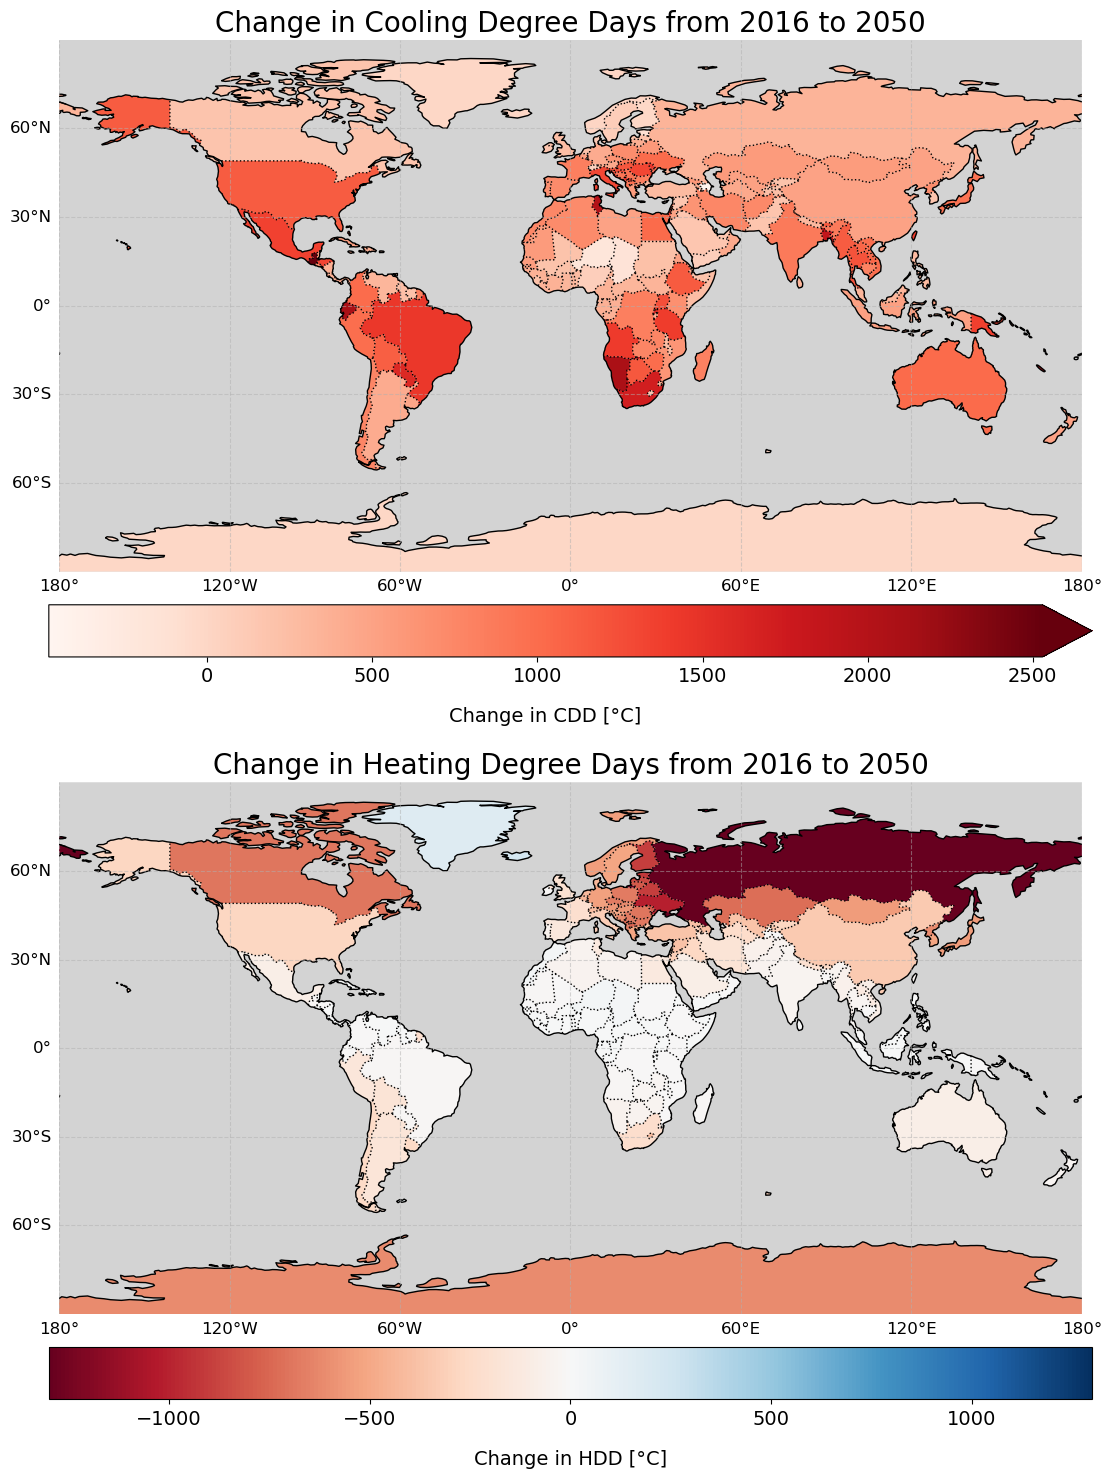

In [123]:
#Plot change in CDD
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(2, 1, figsize=(11, 15), subplot_kw={'projection': projection})
cbar, image = plot_countries(ax[0], world, 'cdd_sum', "Reds", "max", "Change in CDD [°C]","Change in Cooling Degree Days from 2016 to 2050")
cbar, image = plot_countries(ax[1], world, 'hdd_sum', "RdBu", None, "Change in HDD [°C]","Change in Heating Degree Days from 2016 to 2050", vmin = -1300, vmax = 1300)
plt.tight_layout()
plt.show()

### 2. Grouping countries based on their current heat/AC usage

In [124]:
# Function to get the means 

def get_kmeans(data, field1, field2, clustername):
    filt = data.dropna(subset = [field1, field2])
    data = filt[[field1, field2]]
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    kmeans = KMeans(n_clusters=4, random_state=0)  # Change the number of clusters as needed
    kmeans.fit(data_scaled)
    filt[clustername] = kmeans.labels_
    cluster_countries = {i: [] for i in range(kmeans.n_clusters)}
    for i, country in enumerate(filt['Country']):
        cluster_countries[filt[clustername].iloc[i]].append(country)
    return filt, cluster_countries

def add_trendlines(ax, x, y, clusters, cmap):
    unique_clusters = np.unique(clusters)
    for cluster in unique_clusters:
        cluster_mask = clusters == cluster
        x_cluster = x[cluster_mask]
        y_cluster = y[cluster_mask]
        # Fit a linear regression model
        coef = np.polyfit(x_cluster, y_cluster, 1)
        poly1d_fn = np.poly1d(coef)
        # Plot the trendline with the same color as the cluster
        ax.plot(x_cluster, poly1d_fn(x_cluster), linestyle='-', color=cmap(cluster / len(unique_clusters)), label=f'Trendline Cluster {cluster}')


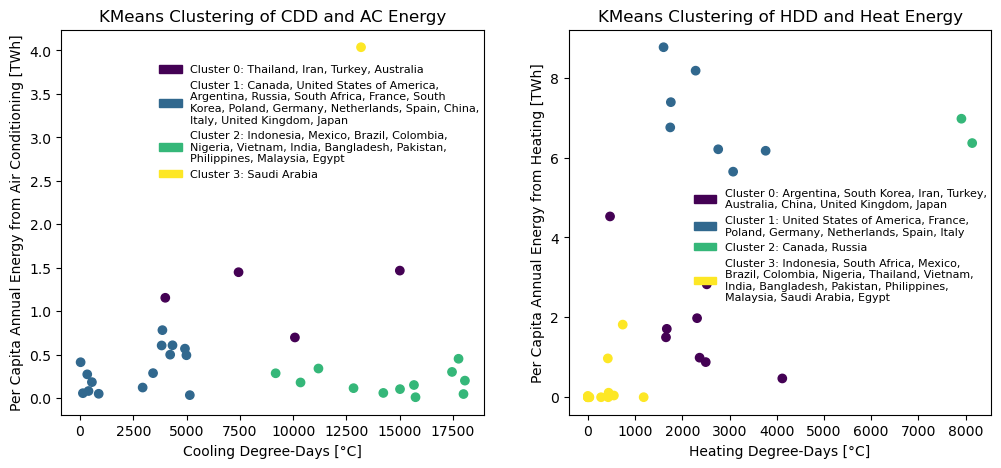

In [125]:
# Plot the scatter plot with color coding for clusters

fig, ax = plt.subplots(1,2, figsize=(12, 5))

#COOLING
world['norm_ac'] = world['AC_energy']/world['pop_2016']

filtered_world, cluster_countries = get_kmeans(world, 'cdd_2016', 'norm_ac', 'cluster_ac')
scatter = ax[0].scatter(filtered_world['cdd_2016'], filtered_world['norm_ac'], c=filtered_world['cluster_ac'], cmap='viridis')
# Wrap text for legend
wrapped_handles = []
for i, countries in cluster_countries.items():
    wrapped_text = textwrap.fill(f'Cluster {i}: {", ".join(countries)}', width=50)
    wrapped_handles.append(mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=wrapped_text))
# Add a legend with the list of countries for each cluster
ax[0].legend(handles=wrapped_handles, fontsize=8, bbox_to_anchor=(1, 0.6), loc='lower right', borderaxespad=0., ncol=1, frameon=False)
ax[0].set_xlabel('Cooling Degree-Days [°C]')
ax[0].set_ylabel('Per Capita Annual Energy from Air Conditioning [TWh]')
ax[0].set_title('KMeans Clustering of CDD and AC Energy')

#HEATING
filtered_world['norm_heat'] = filtered_world['heat_energy']/filtered_world['pop_2016']
filtered_world, cluster_countries = get_kmeans(filtered_world, 'hdd_2016', 'norm_heat', 'cluster_heat')
scatter = ax[1].scatter(filtered_world['hdd_2016'], filtered_world['norm_heat'], c=filtered_world['cluster_heat'], cmap='viridis')
# Wrap text for legend
wrapped_handles = []
for i, countries in cluster_countries.items():
    wrapped_text = textwrap.fill(f'Cluster {i}: {", ".join(countries)}', width=50)
    wrapped_handles.append(mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=wrapped_text))
# Add a legend with the list of countries for each cluster
ax[1].legend(handles=wrapped_handles, fontsize=8, bbox_to_anchor=(1, 0.6), loc='upper right', borderaxespad=0., ncol=1, frameon=False)
ax[1].set_xlabel('Heating Degree-Days [°C]')
ax[1].set_ylabel('Per Capita Annual Energy from Heating [TWh]')
ax[1].set_title('KMeans Clustering of HDD and Heat Energy')

plt.show()

/tmp/ipykernel_1279/3054360197.py:23: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x_cluster, y_cluster, 1)


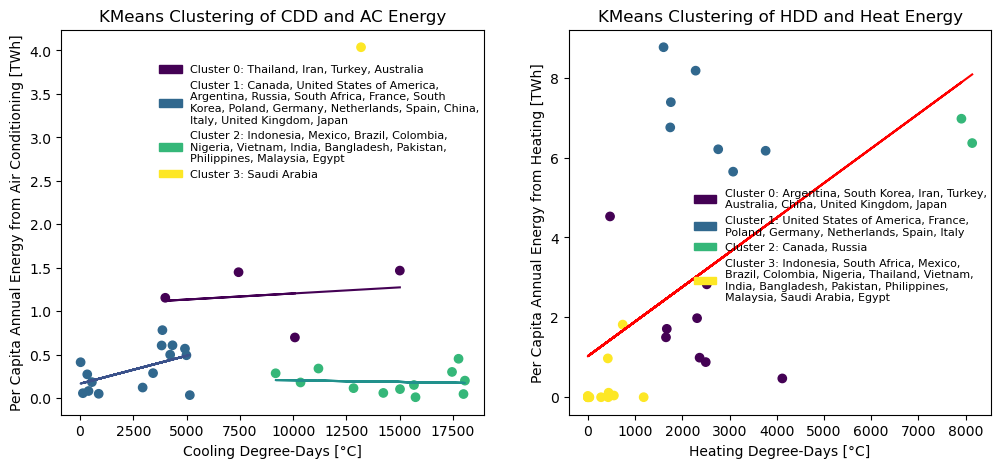

In [126]:
# Plot the scatter plot with color coding for clusters

fig, ax = plt.subplots(1,2, figsize=(12, 5))

#COOLING
world['norm_ac'] = world['AC_energy']/world['pop_2016']

filtered_world, cluster_countries = get_kmeans(world, 'cdd_2016', 'norm_ac', 'cluster_ac')
scatter = ax[0].scatter(filtered_world['cdd_2016'], filtered_world['norm_ac'], c=filtered_world['cluster_ac'], cmap='viridis')
add_trendlines(ax[0], filtered_world['cdd_2016'], filtered_world['norm_ac'], filtered_world['cluster_ac'], cmap=scatter.cmap)
# Wrap text for legend
wrapped_handles = []
for i, countries in cluster_countries.items():
    wrapped_text = textwrap.fill(f'Cluster {i}: {", ".join(countries)}', width=50)
    wrapped_handles.append(mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=wrapped_text))
# Add a legend with the list of countries for each cluster
ax[0].legend(handles=wrapped_handles, fontsize=8, bbox_to_anchor=(1, 0.6), loc='lower right', borderaxespad=0., ncol=1, frameon=False)
ax[0].set_xlabel('Cooling Degree-Days [°C]')
ax[0].set_ylabel('Per Capita Annual Energy from Air Conditioning [TWh]')
ax[0].set_title('KMeans Clustering of CDD and AC Energy')

#HEATING
filtered_world['norm_heat'] = filtered_world['heat_energy']/filtered_world['pop_2016']
filtered_world, cluster_countries = get_kmeans(filtered_world, 'hdd_2016', 'norm_heat', 'cluster_heat')
scatter = ax[1].scatter(filtered_world['hdd_2016'], filtered_world['norm_heat'], c=filtered_world['cluster_heat'], cmap='viridis')
# Get overall trend line: 
coef = np.polyfit(filtered_world['hdd_2016'], filtered_world['norm_heat'], 1)
poly1d_fn = np.poly1d(coef)
# Plot the trendline with the same color as the cluster
ax[1].plot(filtered_world['hdd_2016'], poly1d_fn(filtered_world['hdd_2016']), linestyle='-', color = 'r')


# Wrap text for legend
wrapped_handles = []
for i, countries in cluster_countries.items():
    wrapped_text = textwrap.fill(f'Cluster {i}: {", ".join(countries)}', width=50)
    wrapped_handles.append(mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=wrapped_text))
# Add a legend with the list of countries for each cluster
ax[1].legend(handles=wrapped_handles, fontsize=8, bbox_to_anchor=(1, 0.6), loc='upper right', borderaxespad=0., ncol=1, frameon=False)
ax[1].set_xlabel('Heating Degree-Days [°C]')
ax[1].set_ylabel('Per Capita Annual Energy from Heating [TWh]')
ax[1].set_title('KMeans Clustering of HDD and Heat Energy')

plt.show()

### 3. Method 1: creating a uniform "score" for each country based on relevant factors

In [127]:
#COOLING SCORES: countries with highest potential contribution to future cooling needs

# Reclassify factors and get overall "score" 
#1. Increase in CDD reclass 1-10 (higher = higher score)
#2. Total future population reclass 1-10 (higher = higher score)
#3. GDP diff reclass 1-10 (higher = higher score)
#4. current AC saturation reclass 10-1 (lower = higher score)

# By this point, 'world' should have diff_CDD, pop_2050, gdp diff, AC saturation


world['cdd_rank'] = pd.to_numeric(pd.qcut(world['cdd_sum'], 10, labels=False) + 1)
world['pop_rank'] = pd.to_numeric(pd.qcut(world['pop_2050'], 10, labels=False) + 1)
world['gdp_rank'] = pd.to_numeric(pd.qcut(world['gdp_change'], 10, labels=False) + 1)
world['AC_rank'] = pd.to_numeric(pd.qcut(world['AC_penetration'], 10, labels=range(10, 0, -1), duplicates='drop'))

# Ok now combine all of them into an overall rank 

world['score'] = world[['cdd_rank', 'pop_rank', 'gdp_rank', 'AC_rank']].mean(axis=1, skipna = False)


In [128]:
#HEATING SCORES: countries with highest potential contribution to future heating needs

# Reclassify factors and get overall "score" 
#1. Increase in HDD reclass 1-10 (higher = higher score)
#2. Total future population reclass 1-10 (higher = higher score)
#3. GDP diff reclass 1-10 (higher = higher score)

world['hdd_rank'] = pd.to_numeric(pd.qcut(world['hdd_sum'], 10, labels=False, duplicates='drop') + 1)
# Ok now combine all of them into an overall rank 

world['heat_score'] = world[['hdd_rank', 'pop_rank', 'gdp_rank']].mean(axis=1, skipna = False)


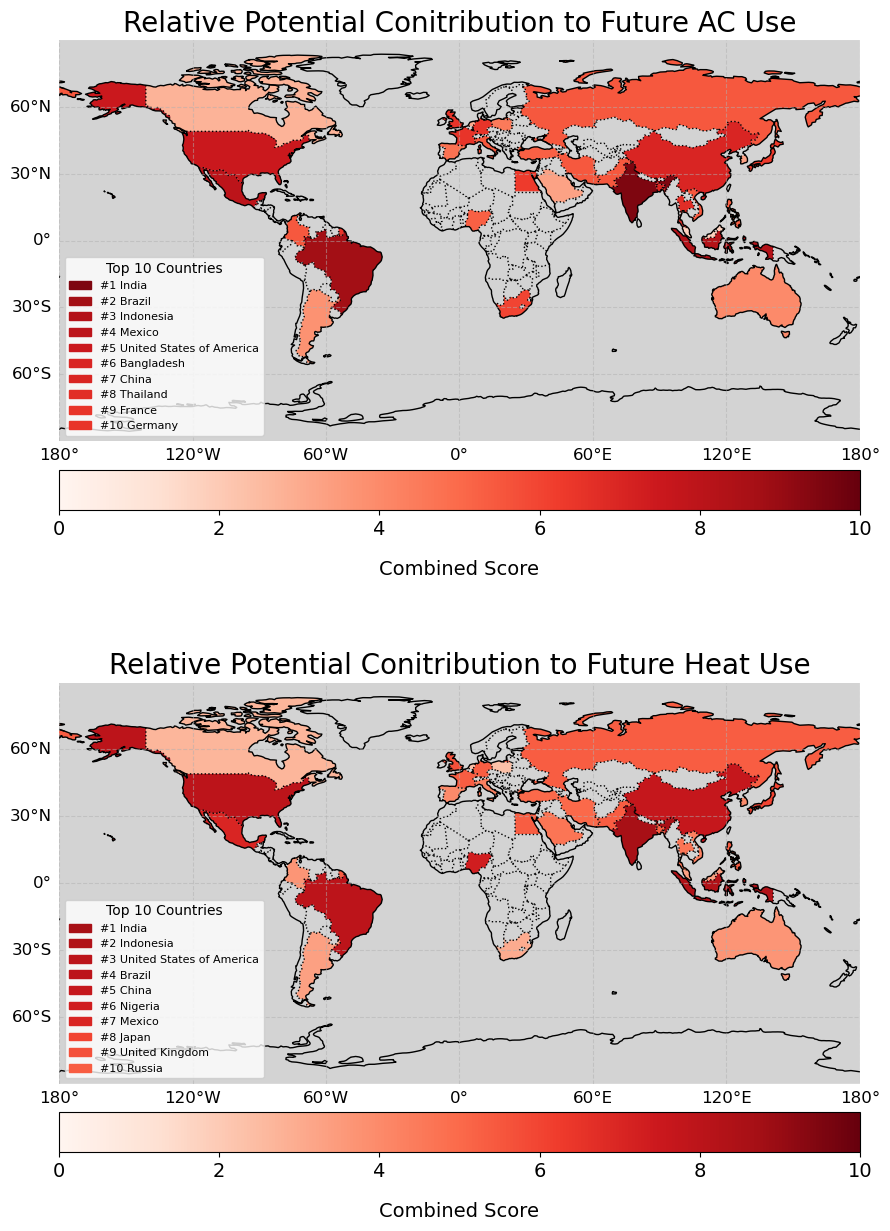

In [129]:
#Now plot the scores!!! 

#FIRST COOLING
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(2, 1, figsize=(9, 13), subplot_kw={'projection': projection})
cbar, image = plot_countries(ax[0], world, 'score', "Reds", None, "Combined Score","Relative Potential Conitribution to Future AC Use", vmin = 0, vmax = 10)
#OK NOW ADD LEGEND!! Want it colour-coded baswd on the score 
top_countries = world.nlargest(10, 'score')
norm = Normalize(vmin=0, vmax=10)
cmap = plt.get_cmap("Reds")
# Create a list to store legend entries
legend_patches = []
# Add annotations for the top 10 countries and create legend entries
for rank, (idx, row) in enumerate(top_countries.iterrows(), start=1):
    score_color = cmap(norm(row['score']))  # Get the color based on the score
    legend_patches.append(mpatches.Patch(color=score_color, label=f"#{rank} {row['Country']}"))
# Add legend to the plot
ax[0].legend(handles=legend_patches, loc='lower left', fontsize=8, title="Top 10 Countries",title_fontsize=10)


# NOW HEATING

#FIRST COOLING
cbar, image = plot_countries(ax[1], world, 'heat_score', "Reds", None, "Combined Score","Relative Potential Conitribution to Future Heat Use", vmin = 0, vmax = 10)
#OK NOW ADD LEGEND!! Want it colour-coded baswd on the score 
top_countries = world.nlargest(10, 'heat_score')
norm = Normalize(vmin=0, vmax=10)
cmap = plt.get_cmap("Reds")
# Create a list to store legend entries
legend_patches = []
# Add annotations for the top 10 countries and create legend entries
for rank, (idx, row) in enumerate(top_countries.iterrows(), start=1):
    score_color = cmap(norm(row['heat_score']))  # Get the color based on the score
    legend_patches.append(mpatches.Patch(color=score_color, label=f"#{rank} {row['Country']}"))
# Add legend to the plot
ax[1].legend(handles=legend_patches, loc='lower left', fontsize=8, title="Top 10 Countries",title_fontsize=10)


plt.tight_layout()
plt.show()

### 4. Method 2: multiple regression

In [130]:
#2a. Multiple linear regression to predict future AC usage (COOL MODEL)


#define the variables
X = filtered_world[['cdd_2016', 'pop_2016', 'gdp_2016']]
y = filtered_world['AC_energy']

#add a constant to the independent variables matrix (from the internet idk why we do this??)
X = sm.add_constant(X)

#make the model
model = sm.OLS(y, X).fit()

#print results
print(model.summary())

#predict!!
X_2050 = filtered_world[['cdd_2050', 'pop_2050', 'gdp_2050']]
X_2050 = sm.add_constant(X_2050)
y_pred_2050 = model.predict(X_2050)

#evaluate performance
y_pred_ac = model.predict(X)
mse = mean_squared_error(y, y_pred_ac)
r2_cool = r2_score(y, y_pred_ac)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2_cool}')

#Add to our df: 

filtered_world['AC_2050'] = y_pred_2050

                            OLS Regression Results                            
Dep. Variable:              AC_energy   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     41.43
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           1.99e-10
Time:                        16:40:14   Log-Likelihood:                -159.35
No. Observations:                  32   AIC:                             326.7
Df Residuals:                      28   BIC:                             332.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.8175     13.490     -0.654      0.5

In [131]:
#2b. Linear regression: Heat model trained on (GDP, population, HDD) --> heat energy. Then run on future scenario.

#define the variables
X = filtered_world[['hdd_2016', 'pop_2016', 'gdp_2016']]
y = filtered_world['heat_energy']

#add a constant to the independent variables matrix (from the internet idk why we do this??)
X = sm.add_constant(X)

#make the model
model = sm.OLS(y, X).fit()

#print results
print(model.summary())

#predict!!
X_2050 = filtered_world[['hdd_2050', 'pop_2050', 'gdp_2050']]
X_2050 = sm.add_constant(X_2050)
y_pred_2050 = model.predict(X_2050)

#evaluate performance
y_pred_heat = model.predict(X)
mse = mean_squared_error(y, y_pred_heat)
r2_heat = r2_score(y, y_pred_heat)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2_heat}')

#Add to our df: 

filtered_world['heat_2050'] = y_pred_2050

                            OLS Regression Results                            
Dep. Variable:            heat_energy   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     36.78
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           7.55e-10
Time:                        16:40:31   Log-Likelihood:                -210.81
No. Observations:                  32   AIC:                             429.6
Df Residuals:                      28   BIC:                             435.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7826     46.812     -0.145      0.8

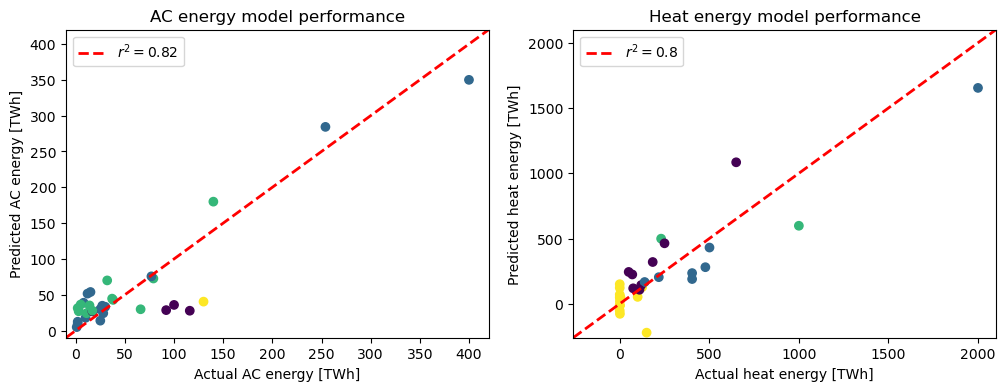

In [132]:
#Plot performance 
#COOLING

fig, ax = plt.subplots(1,2, figsize=(12, 4))
scatter = ax[0].scatter(filtered_world['AC_energy'], y_pred_ac, c=filtered_world['cluster_ac'], cmap='viridis')
ax[0].set_xlim([-10, 420])
ax[0].set_ylim([-10, 420])
ax[0].plot([-10, 420], [-10, 420], 'r--', lw=2, label=fr"$r^{{2}} = {round(r2_cool, 2)}$")
ax[0].set_xlabel('Actual AC energy [TWh]')
ax[0].set_ylabel('Predicted AC energy [TWh]')
ax[0].set_title('AC energy model performance')
ax[0].legend()

scatter2 = ax[1].scatter(filtered_world['heat_energy'], y_pred_heat, c=filtered_world['cluster_heat'], cmap='viridis')
ax[1].set_xlim([-260, 2100])
ax[1].set_ylim([-260, 2100])
ax[1].plot([-260, 2100], [-260, 2100],'r--', lw=2,label=fr"$r^{{2}} = {round(r2_heat, 2)}$")
ax[1].set_xlabel('Actual heat energy [TWh]')
ax[1].set_ylabel('Predicted heat energy [TWh]')
ax[1].set_title('Heat energy model performance')
ax[1].legend()



plt.show()


In [133]:
#2c. Plot future AC (or change in AC), future heat (or change in heat), and the difference between the changes
#(i.e. AC increases by X amount, heat decreases by Y amount, what's the difference?)


#First- fix so there is no negative heat energy

#get change in PREDICTED values 
y_pred_heat[y_pred_heat<0] = 0
filtered_world['heat_2050'][filtered_world['heat_2050']<0] = 0

filtered_world['change_AC'] = filtered_world['AC_2050'] - y_pred_ac

filtered_world['change_heat'] = filtered_world['heat_2050'] - y_pred_heat

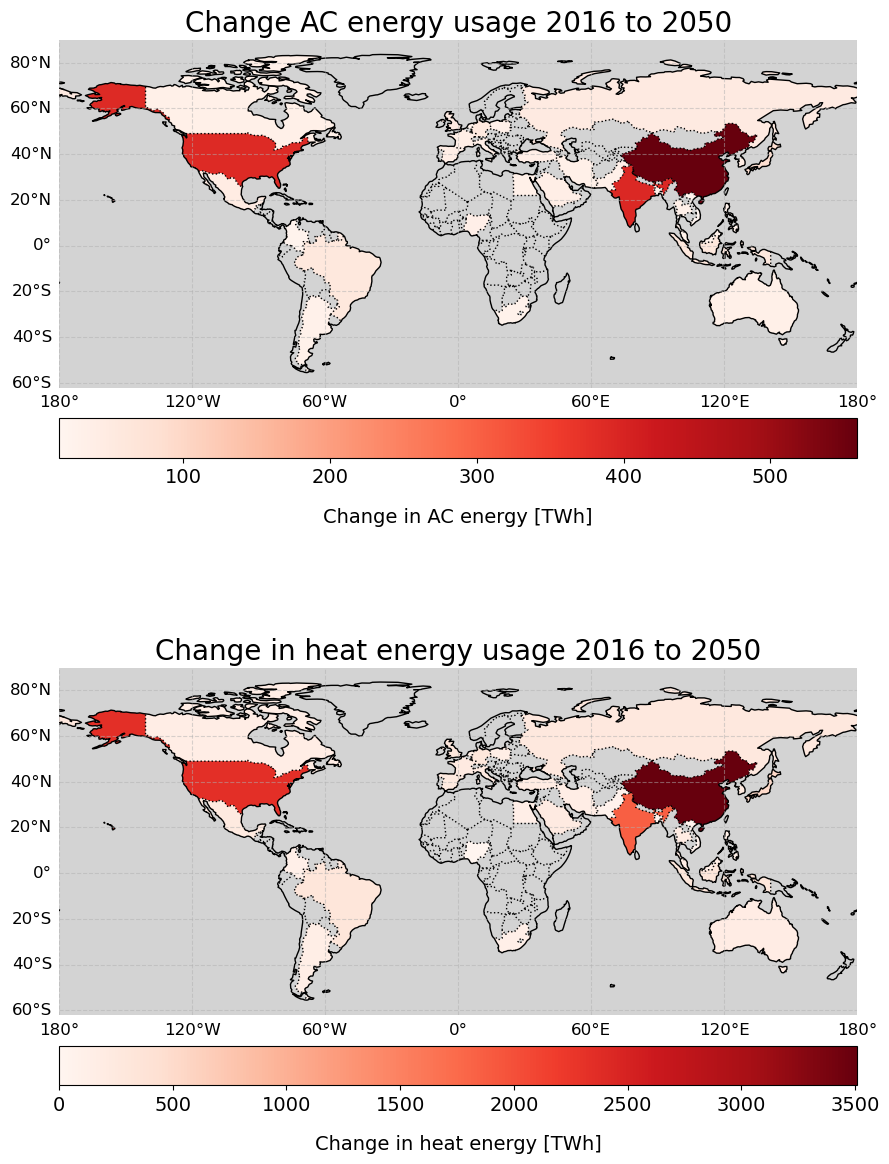

In [134]:
#Ok now plot!

#Plot change in HDD
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(2, 1, figsize=(9, 13), subplot_kw={'projection': projection})
cbar, image = plot_countries(ax[0], filtered_world, 'change_AC', "Reds", None, "Change in AC energy [TWh]","Change AC energy usage 2016 to 2050")
cbar, image = plot_countries(ax[1], filtered_world, 'change_heat', "Reds", None, "Change in heat energy [TWh]","Change in heat energy usage 2016 to 2050")
plt.tight_layout()
plt.show()


### 5. Method 3: simple regression

In [135]:
# Prepare the data
X = filtered_world[['cdd_2016']]
y = filtered_world['AC_energy']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Measure performance
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Create a DataFrame for prediction with the same feature names
cdd_2050_df = filtered_world[['cdd_2050']].rename(columns={'cdd_2050': 'cdd_2016'})

# Predict for 2050 using the same feature name as during training
filtered_world['AC_2050_2'] = model.predict(cdd_2050_df)
filtered_world['change_AC_2'] = filtered_world['AC_2050_2'] - model.predict(filtered_world[['cdd_2016']])

Mean Absolute Error: 97.26531849372073


In [136]:
# NOW HEATING
X_heat = filtered_world[['hdd_2016']]
y_heat = filtered_world['heat_energy']

# Split the data
X_train_heat, X_test_heat, y_train_heat, y_test_heat = train_test_split(X_heat, y_heat, test_size=0.2, random_state=4)

# Train the model
model_heat = LinearRegression()
model_heat.fit(X_train_heat, y_train_heat)

# Make predictions
y_pred_heat = model_heat.predict(X_test_heat)

# Measure performance
mae = mean_absolute_error(y_test_heat, y_pred_heat)
print(f'Mean Absolute Error: {mae}')

# Create a DataFrame for prediction with the same feature names
cdd_2050_df = filtered_world[['hdd_2050']].rename(columns={'hdd_2050': 'hdd_2016'})

# Predict for 2050 using the same feature name as during training
filtered_world['heat_2050_2'] = model_heat.predict(cdd_2050_df)
filtered_world['change_heat_2'] = filtered_world['heat_2050_2'] - model_heat.predict(filtered_world[['hdd_2016']])

Mean Absolute Error: 131.003299555691


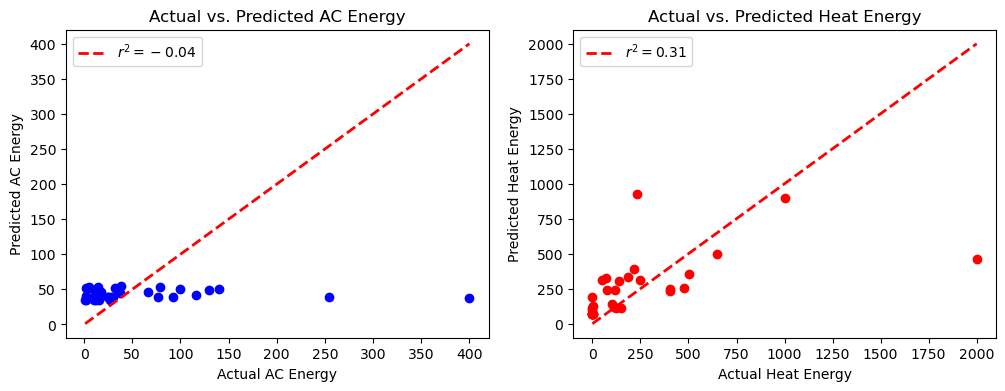

In [138]:
# Calculate r-squared value for the whole dataset
y_all_pred = model.predict(X)
r2 = r2_score(y, y_all_pred)

y_all_pred_heat = model_heat.predict(X_heat)
r2_heat = r2_score(y_heat, y_all_pred_heat)

fig, ax = plt.subplots(1,2, figsize=(12, 4))

# Plot actual vs. predicted values
ax[0].scatter(y, y_all_pred, color='blue')
ax[0].plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=2, label=fr"$r^{{2}} = {round(r2, 2)}$")

# Add labels and legend
ax[0].set_xlabel('Actual AC Energy')
ax[0].set_ylabel('Predicted AC Energy')
ax[0].set_title('Actual vs. Predicted AC Energy')
ax[0].legend()

#ok now for heat 
ax[1].scatter(y_heat, y_all_pred_heat, color='red')
ax[1].plot([min(y_heat), max(y_heat)], [min(y_heat), max(y_heat)], 'r--', lw=2, label=fr"$r^{{2}} = {round(r2_heat, 2)}$")

# Add labels and legend
ax[1].set_xlabel('Actual Heat Energy')
ax[1].set_ylabel('Predicted Heat Energy')
ax[1].set_title('Actual vs. Predicted Heat Energy')
ax[1].legend()

plt.show()

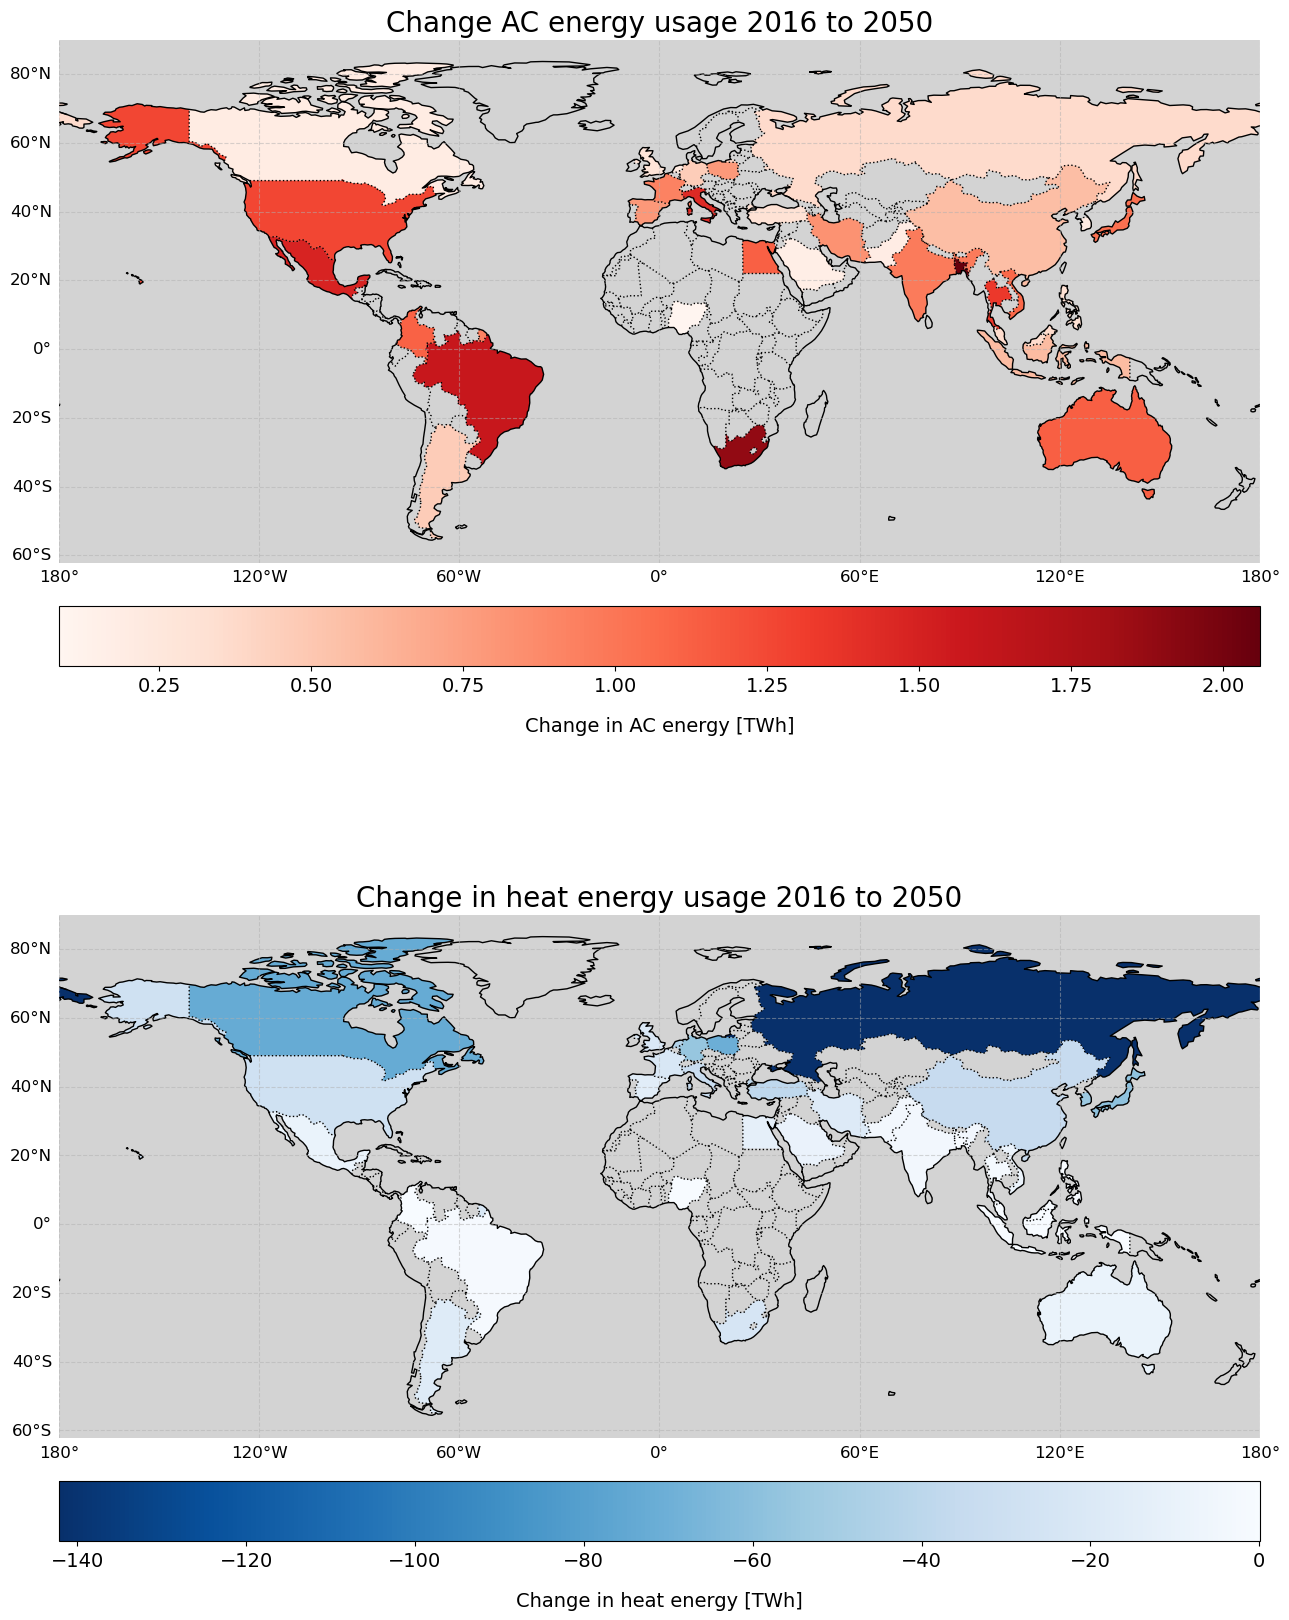

In [139]:
#Ok now plot!

#Plot change in HDD
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(2, 1, figsize=(13, 18), subplot_kw={'projection': projection})
cbar, image = plot_countries(ax[0], filtered_world, 'change_AC_2', "Reds", None, "Change in AC energy [TWh]","Change AC energy usage 2016 to 2050")
cbar, image = plot_countries(ax[1], filtered_world, 'change_heat_2', "Blues_r", None, "Change in heat energy [TWh]","Change in heat energy usage 2016 to 2050")
plt.tight_layout()
plt.show()

## Conclusions 
- Multiple regression potentially best for predicting future AC energy
- Single regression potentially best for predicting future heat energy 
- Future work: multiple regression for heat energy, mask out any countries where HDD are less than certain threshold


# Thank you! :)